In [97]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import numpy.lib.recfunctions as rfn
from scipy.cluster.hierarchy import dendrogram, leaves_list, linkage
import statsmodels.formula.api
import statsmodels.api
import pylab
from scipy import stats

In [85]:
#STEP 0 (parts 0-3)
#input_arr = np.genfromtxt("dros_gene_expression.csv", delimiter=',', names=True, dtype=None, encoding='utf-8')
#col_names = list(input_arr.dtype.names[1:])
#gene_names = input_arr["t_name"]
#fpkm_values = input_arr[col_names[1:]]
#fpkm_values_2d = rfn.structured_to_unstructured(fpkm_values, dtype=float)

#median = np.median(fpkm_values_2d, axis=1)
#filtered_array = np.log2(fpkm_values_2d[np.where(median>0)]+ 0.1)

In [86]:
#STEP 0
input_arr = np.genfromtxt("dros_gene_expression.csv", delimiter=',', names=True, dtype=None, encoding='utf-8')
gene_names = input_arr["t_name"] 
fpkm_values = input_arr[["male_10", "male_11", "male_12", "male_13", "male_14", "female_10", "female_11", "female_12", "female_13", "female_14"]] 
col_names = fpkm_values.dtype.names 
fpkm_values_2d = rfn.structured_to_unstructured(fpkm_values, dtype=float)

In [87]:
medians = np.median(fpkm_values_2d, axis=1) 
roi = medians > 0 
fpkm_values_2d_filt = fpkm_values_2d[roi,] 
fpkm_values_2d_filt_transform = np.log2(fpkm_values_2d_filt + 0.1) 

In [88]:
#STEP 1 (Part 1)
linkaged_matrix = linkage(fpkm_values_2d_filt_transform, method='single', metric='euclidean', optimal_ordering=False)
transposed_matrix = np.transpose(fpkm_values_2d_filt_transform, axes=None)
linkaged_transposed_matrix = linkage(transposed_matrix, method='single', metric='euclidean', optimal_ordering=False)

In [89]:
leaf_node_list_l = leaves_list(linkaged_matrix)
leaf_node_list_lt = leaves_list(linkaged_transposed_matrix)

In [90]:
sorted_data = fpkm_values_2d_filt_transform[leaf_node_list_l,:] 
further_sorted_data = sorted_data[:,leaf_node_list_lt]

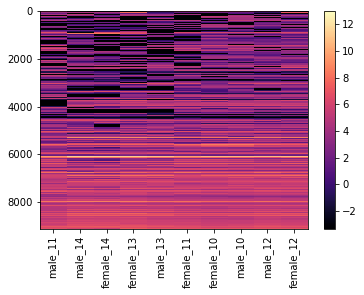

In [91]:
#STEP 1 (Part 2)
fig, ax = plt.subplots() # initialize your fix,ax
plt.imshow(further_sorted_data, aspect = 'auto', cmap='magma', interpolation = "nearest")
ax.set_xticks(np.arange(len(col_names)))
ax.set_xticklabels(np.array(col_names)[leaf_node_list_lt], rotation = 90)
plt.colorbar()

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [55.0, 55.0, 73.75, 73.75],
  [45.0, 45.0, 64.375, 64.375],
  [35.0, 35.0, 54.6875, 54.6875],
  [20.0, 20.0, 44.84375, 44.84375],
  [5.0, 5.0, 32.421875, 32.421875]],
 'dcoord': [[0.0, 187.2246545022748, 187.2246545022748, 0.0],
  [0.0, 168.86566984603502, 168.86566984603502, 0.0],
  [0.0, 178.44202458035923, 178.44202458035923, 168.86566984603502],
  [0.0, 187.15141311928198, 187.15141311928198, 178.44202458035923],
  [0.0, 231.00960788126972, 231.00960788126972, 187.15141311928198],
  [0.0, 235.67560030850902, 235.67560030850902, 231.00960788126972],
  [0.0, 238.19422623843465, 238.19422623843465, 235.67560030850902],
  [187.2246545022748,
   239.03526007482375,
   239.03526007482375,
   238.19422623843465],
  [0.0, 248.83473585290707, 248.83473585290707, 239.03526007482375]],
 'ivl': ['male_11',
  'male_14',
  'female_14',
  'female_13',
  'male_13',
  'female_

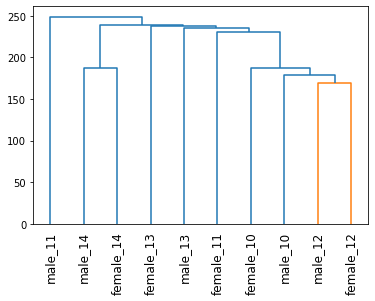

In [92]:
#STEP 1 (Part 3)
dendrogram(linkaged_transposed_matrix, labels=col_names, leaf_rotation = 90)

In [93]:
# STEP 2
# Part 1: generate OLS regression 

# prepare variables 
sex = []
stage = []
for i in col_names:
    sex.append(i.split("_")[0])
    stage.append(i.split("_")[1])

In [104]:
# create OLS framework
p_values_stage = []
for i in range(fpkm_values_2d_filt_transform.shape[0]):
   list_of_tuples = []
   for j in range(len(col_names)):
     list_of_tuples.append((gene_names[i],fpkm_values_2d_filt_transform[i,j], sex[j], stage[j]))
   longdf = np.array(list_of_tuples, dtype=[('gene', 'S11'), ('fpkm', float), ('sex', 'S6'), ('stage', int)])

    # run OLS 
   statmodel_out = statsmodels.formula.api.ols(formula='fpkm ~ stage + sex', data=longdf).fit()
   p_values_stage.append(statmodel_out.pvalues["stage"]) 

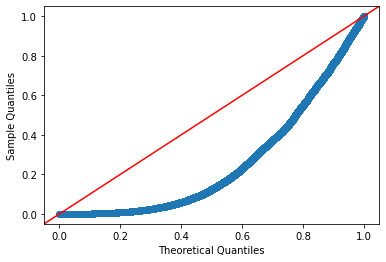

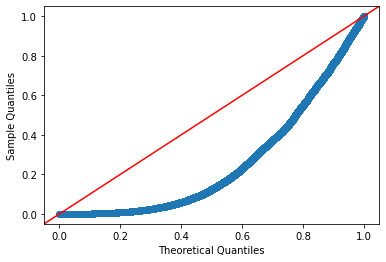

In [105]:
statsmodels.api.qqplot(np.array(p_values_stage), dist = stats.uniform, line='45')

In [ ]:
sum(statsmodels.stats.multitest.multipletests(p_values_stage, alpha=0.05, method='hs', is_sorted=False, returnsorted=False))